In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)
import numpy as np

/home/agustina/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Code 6.1

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,brain,mass,species
0,438,37.0,afarensis
1,452,35.5,africanus
2,612,34.5,habilis
3,521,41.5,boisei
4,752,55.5,rudolfensis
5,871,61.0,ergaster
6,1350,53.5,sapiens


#### Code 6.2

In [3]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [4]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.4901580479490838

#### Code 6.4

In [5]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [6]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [7]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [8]:
d_new = d.drop(d.index[-1])

#### Code 6.8

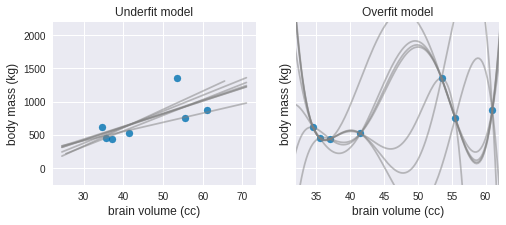

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [10]:
p = (0.3, 0.7)
-sum(p*np.log(p))

0.6108643020548935

#### Code 6.10

In [11]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.924989685887581

#### Code 6.11

In [15]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain'])*10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(1000) 

100%|██████████| 1500/1500 [00:03<00:00, 494.98it/s]/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:447: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8805603355, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [16]:
theta = pm.df_summary(m_6_8)['mean'][:3]

In [17]:
#compute deviance
dev = -2*sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1]*d['mass_s']  , scale = theta[2]))
dev

100.68034056380928

#### Code 6.12

In [29]:
###import sim.train.test function
from rpy2.robjects.packages import STAP

with open('R functions/sim_train_test.r', 'r') as f:
    string = f.read()
sim_train_test = STAP(string, 'sim_train_test')

In [30]:
sim_train_test.sim_train_test()

/home/agustina/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in (function (N = 20, k = 3, rho = c(0.15, -0.4), b_sigma = 100,  : 
  could not find function "mvrnorm"

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in (function (N = 20, k = 3, rho = c(0.15, -0.4), b_sigma = 100,  : 
  could not find function "mvrnorm"


In [44]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

In [62]:
np.array([4]).shape

(1,)

In [64]:
A = np.array([[1,1,1],[2,2,2],[3,3,3]])
d = np.diag(np.array([4]))
print(d)
#np.tril(A)


[[4]]


In [45]:
string = '''sim.train.test <- function( N=20 , k=3 , rho=c(0.15,-0.4) , b_sigma=100 , DIC=FALSE , WAIC=FALSE, devbar=FALSE , devbarout=FALSE ) {
    #require(MASS)
    n_dim <- 1+length(rho)
    if ( n_dim < k ) n_dim <- k
    Rho <- diag(n_dim)
    for ( i in 1:length(rho) ) {
        Rho[1,i+1] <- rho[i]
    }
    Rho[lower.tri(Rho)] <- Rho[upper.tri(Rho)]
    X.train <- mvrnorm( n=N , mu=rep(0,n_dim) , Sigma=Rho )
    X.test <- mvrnorm( n=N , mu=rep(0,n_dim) , Sigma=Rho )
    mm.train <- matrix(1,nrow=N,ncol=1)
    bnames <- "a"
    if ( k > 1 ) {
        mm.train <- cbind( mm.train , X.train[,2:k] )
        bnames <- c( "a" , paste("b",1:(k-1),sep="") )
        pnames <- paste("b",1:(k-1),sep="")
        P <- paste( "c(" , paste(pnames,collapse=",") , ")" , sep="" , collapse="" )
        Pf <- paste( P , "~ dnorm(0,",b_sigma,")" )
    }
    B <- paste( "c(" , paste(bnames,collapse=",") , ")" , sep="" , collapse="" )
    d <- list( y=X.train[,1] , mm=mm.train , Bvec=B )
    #m <- lm.fit( mm.train , X.train[,1] )
    flist <- list( y ~ dnorm( mu , 1 ) , mu ~ 0 + mm %*% eval(parse(text=Bvec)) )
    start.list <- list(a=0)
    if ( k>1 ) {
        flist[[3]] <- eval(parse(text=Pf))
        for ( i in 2:k ) {
            ptext <- paste( "b" , i-1 , sep="" , collapse="" )
            start.list[[i]] <- 0
            names(start.list)[i] <- ptext
        }
    }
    m <- map( flist , data=d , start=start.list )
    dev.train <- as.numeric( deviance(m) )
    mm.test <- matrix(1,nrow=N,ncol=1)
    if ( k > 1 ) mm.test <- cbind( mm.test , X.test[,2:k] )
    dev.test <- (-2)*sum( dnorm( X.test[,1] , mm.test %*% coef(m) , 1 , TRUE ) )
    # result
    result <- c( dev.train , dev.test )
    # DIC and WAIC
    if ( DIC==TRUE ) result <- c( result , as.numeric(DIC(m)) )
    if ( WAIC==TRUE ) {
        n_samples <- 1e3
        l <- link(m,n=n_samples,refresh=0)
        lppd <- 0
        pD <- 0
        for ( i in 1:N ) {
            ll <- dnorm( X.train[i,1] , l[,i] , 1 , TRUE )
            lppd <- lppd + log_sum_exp(ll) - log(n_samples)
            pD <- pD + var(ll)
        }
        result <- c( result , -2*(lppd-pD) )
    }
    if ( devbar==TRUE ) {
        post <- extract.samples( m , n=1e3 )
        dev <- sapply( 1:nrow(post) , function(i) 
            (-2)*sum( dnorm( X.train[,1] , mm.train %*% as.numeric(post[i,]) , 1 , TRUE ) )
        )
        result <- c( result , mean(dev) )
    }
    if ( devbarout==TRUE ) {
        post <- extract.samples( m , n=1e3 )
        dev <- sapply( 1:nrow(post) , function(i) 
            (-2)*sum( dnorm( X.test[,1] , mm.test %*% as.numeric(post[i,]) , 1 , TRUE ) )
        )
        result <- c( result , mean(dev) )
    }
    # return
    return(result)
}'''

In [38]:
powerpack = SignatureTranslatedAnonymousPackage(string, "powerpack")

In [43]:
powerpack.sim_train_test(N = 20, k = 3)

/home/agustina/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in (function (N = 20, k = 3, rho = c(0.15, -0.4), b_sigma = 100,  : 
  could not find function "mvrnorm"

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in (function (N = 20, k = 3, rho = c(0.15, -0.4), b_sigma = 100,  : 
  could not find function "mvrnorm"


In [ ]:
N = 20
kseq = range(1,6)
dev = 

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

#### Code 6.x

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))